#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [ ]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time, random, os

In [ ]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/Tesis/Datos

/content/gdrive/MyDrive/Tesis/Datos


In [ ]:
#Setear semilla
np.random.seed(42)
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

#Resultados

##Transformer

Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [ ]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

###Cargar NARX

In [ ]:
result_gru=pd.read_csv('results_Transformer_Wallmart.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
178,178,Transformer_Wallmart_36_4_300_10.0_128.0_5.0_0...,36,4,224.736534,0.609232,0.780533,0.608841,158.214401
199,199,Transformer_Wallmart_40_5_300_20.0_96.0_8.0_0....,40,5,142.612928,0.640598,0.800374,0.607534,247.272110
224,224,Transformer_Wallmart_45_5_300_10.0_96.0_8.0_0....,45,5,229.324226,0.649870,0.806145,0.620491,249.633835
233,233,Transformer_Wallmart_47_4_300_40.0_128.0_4.0_0...,47,4,66.911855,0.657868,0.811091,0.606853,293.369202
218,218,Transformer_Wallmart_44_4_300_20.0_64.0_8.0_0....,44,4,121.503838,0.669409,0.818174,0.649393,192.977905


In [ ]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo

'Transformer_Wallmart_36_4_300_10.0_128.0_5.0_0.47_192.0_3.563909354356966e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_Transformer'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.563909354356966e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Narmax

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], 1, serie.shape[1]))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [ ]:
target_shape

(142, 1)

In [ ]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [ ]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 4ms/step


###4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [ ]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.901107
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-1.179090
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.828641
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.894223


In [ ]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

###Exportar resultados Narmax


In [ ]:
result_mlp=pd.read_csv('Narmax_results_Transformer_Wallmart.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
172,172,Transformer_Wallmart_35_3_800_20.0_256.0_8.0_0...,35,3,248.451145,0.462994,0.680436,0.505869,187.493332
143,143,Transformer_Wallmart_29_4_800_40.0_128.0_7.0_0...,29,4,171.014874,0.469810,0.685427,0.517316,202.082199
17,17,Transformer_Wallmart_4_3_800_10.0_256.0_7.0_0....,4,3,460.828202,0.477908,0.691309,0.510906,201.069534
152,152,Transformer_Wallmart_31_3_800_20.0_96.0_7.0_0....,31,3,248.921013,0.482110,0.694341,0.523545,212.977966
178,178,Transformer_Wallmart_36_4_800_10.0_96.0_8.0_0....,36,4,298.431125,0.483665,0.695460,0.510977,192.902740


In [ ]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo="Narmax_Transformer_Wallmart_35_3_800_20.0_256.0_8.0_0.44_192.0_4.705809759456389e-05"

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_Transformer'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.705809759456389e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [ ]:
Y_test.shape

(580, 1)

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)
results = results.reshape(shape_y_test)
Y_test = Y_test.reshape(shape_y_test)


19/19 [==============================] - 0s 5ms/step


In [ ]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series_result_predict=divide_array(results,20)
series_result_real=divide_array(Y_test,20)

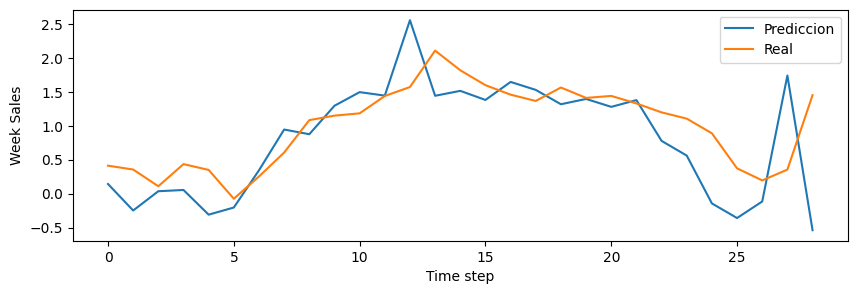

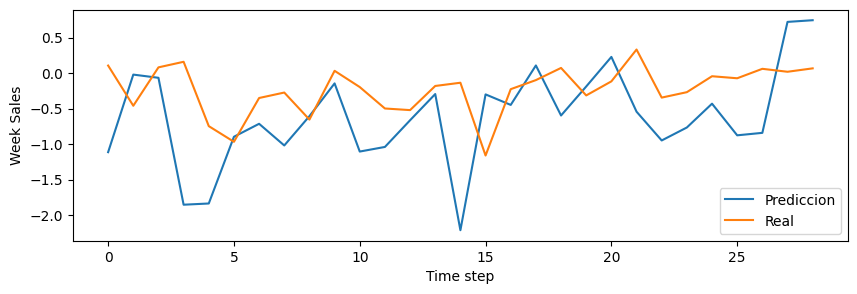

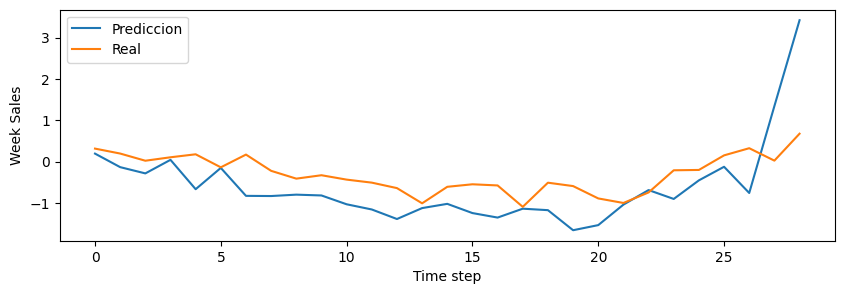

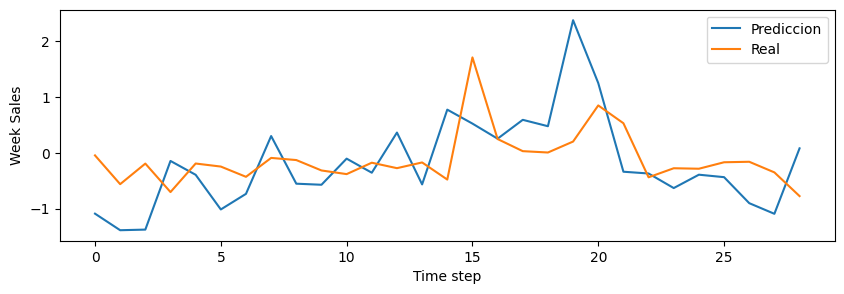

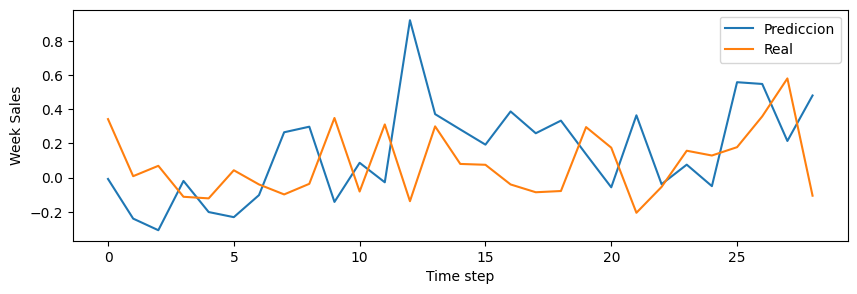

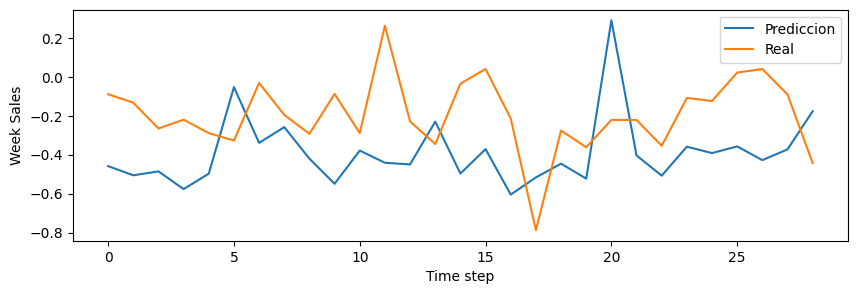

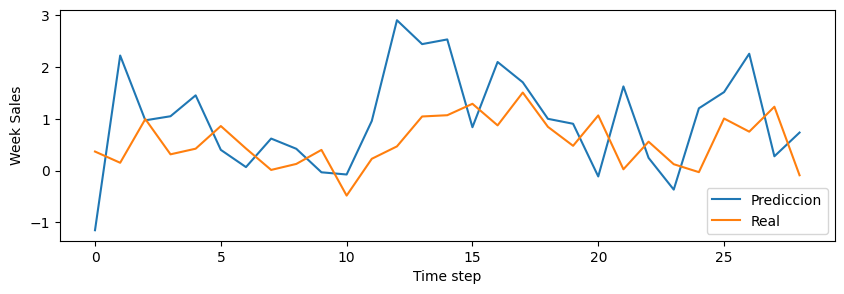

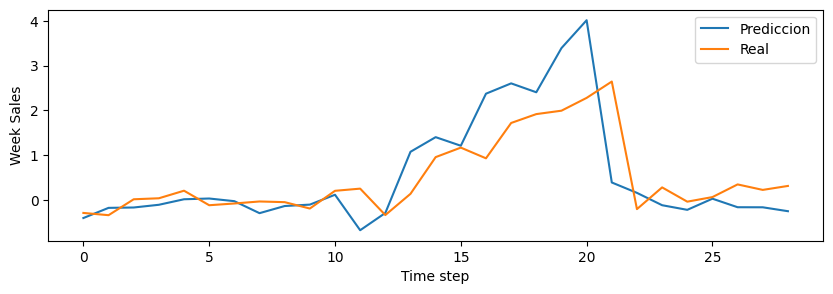

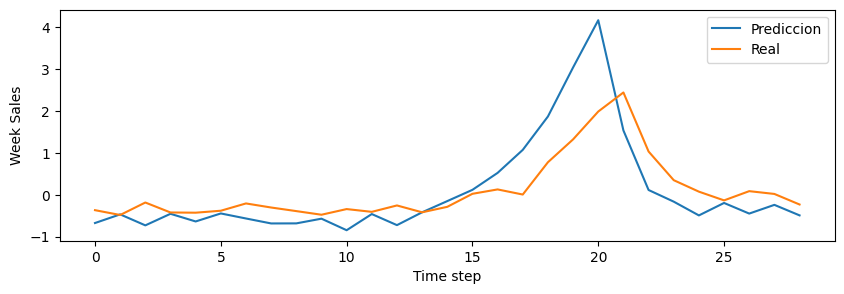

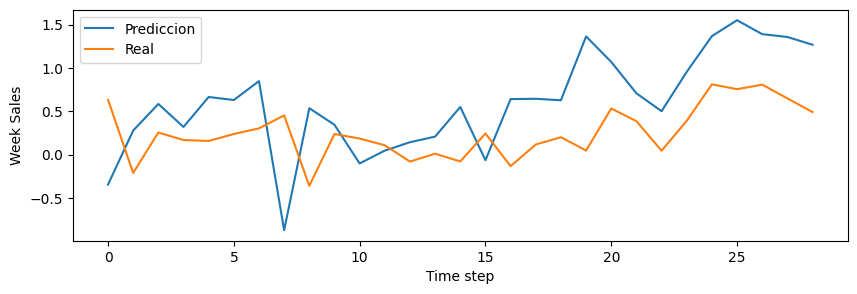

In [ ]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(10,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()

##GRU

Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [ ]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

###Cargar NARX

In [ ]:
result_gru=pd.read_csv('results_GRU_Wallmart.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
72,72,GRU_Wallmart_15_3_800_20.0_3.0_660.0_0.46_adam...,15,3,55.877682,0.449797,0.670669,0.484561,214.838333
57,57,GRU_Wallmart_12_3_800_50.0_1.0_240.0_0.68_adam...,12,3,51.905466,0.453476,0.673406,0.496651,208.590561
237,237,GRU_Wallmart_48_3_800_20.0_3.0_280.0_0.49_adam...,48,3,120.234842,0.454149,0.673906,0.496059,211.382980
42,42,GRU_Wallmart_9_3_800_40.0_3.0_680.0_0.68_adam_...,9,3,48.516264,0.456342,0.675531,0.495815,203.691544
97,97,GRU_Wallmart_20_3_800_50.0_2.0_760.0_0.58_adam...,20,3,22.625808,0.457379,0.676298,0.495662,192.737686


In [ ]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo

'GRU_Wallmart_15_3_800_20.0_3.0_660.0_0.46_adam_2.826400498186163e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_GRU'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=2.826400498186163e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Narmax

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], 1, serie.shape[1]))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [ ]:
target_shape

(142, 1)

In [ ]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [ ]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 18ms/step


###4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [ ]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.668983
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.309605
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.549603
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.643011


In [ ]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

###Exportar resultados Narmax


In [ ]:
result_mlp=pd.read_csv('Narmax_results_GRU_Wallmart.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
104,104,GRU_Wallmart_21_5_800_10.0_3.0_360.0_0.7_adam_...,21,5,214.149539,0.456498,0.675646,0.492126,194.549881
134,134,GRU_Wallmart_27_5_800_100.0_3.0_320.0_0.55_ada...,27,5,42.033451,0.464447,0.681503,0.500632,190.808731
119,119,GRU_Wallmart_24_5_800_20.0_3.0_420.0_0.59_adam...,24,5,82.952432,0.464662,0.681661,0.499837,193.489426
79,79,GRU_Wallmart_16_5_800_50.0_2.0_400.0_0.52_adam...,16,5,36.830282,0.465196,0.682053,0.499571,184.593735
234,234,GRU_Wallmart_47_5_800_90.0_2.0_260.0_0.58_adam...,47,5,35.925428,0.467111,0.683455,0.504095,186.818695


In [ ]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'GRU_Wallmart_21_5_800_10.0_3.0_360.0_0.7_adam_2.5541795969647017e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_GRU'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=2.5541795969647017e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [ ]:
Y_test.shape

(580, 1, 1)

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)
results = results.reshape(shape_y_test)
Y_test = Y_test.reshape(shape_y_test)


19/19 [==============================] - 2s 9ms/step


In [ ]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series_result_predict=divide_array(results,20)
series_result_real=divide_array(Y_test,20)

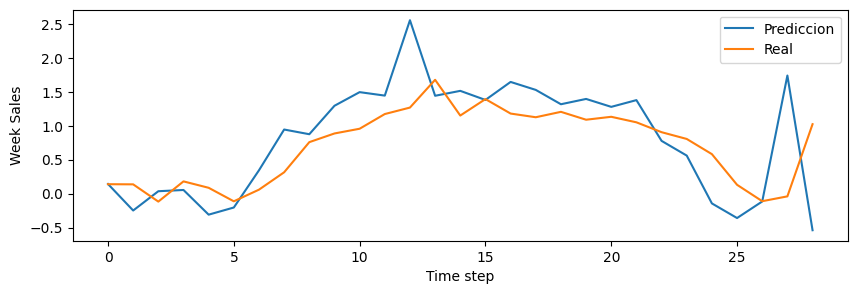

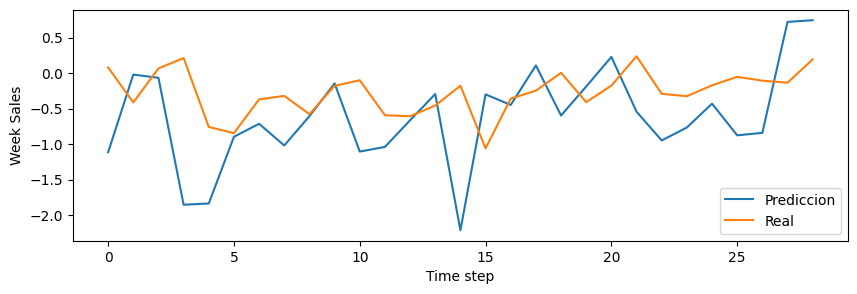

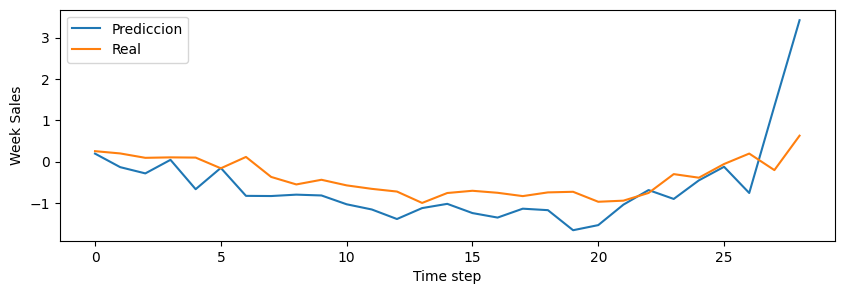

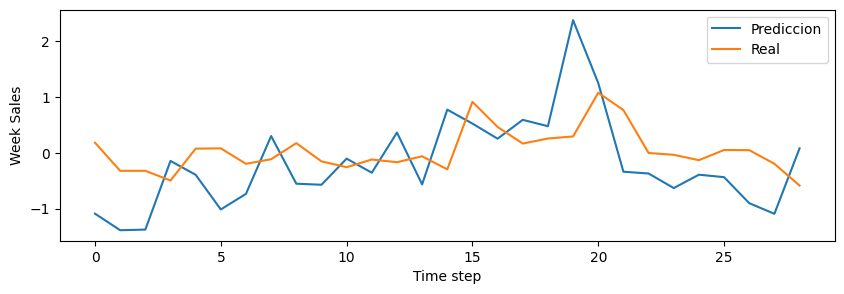

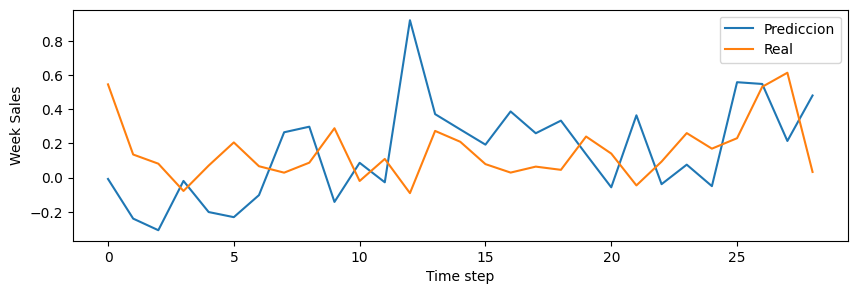

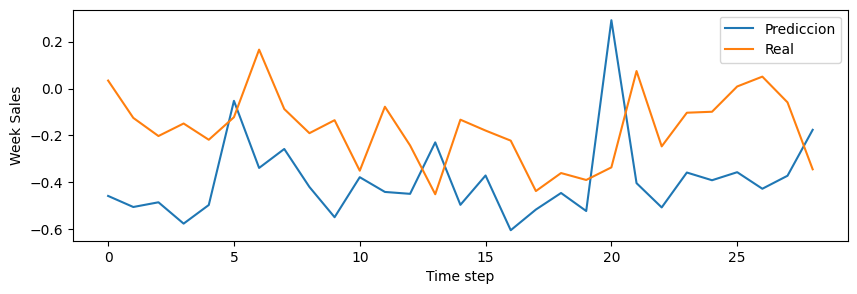

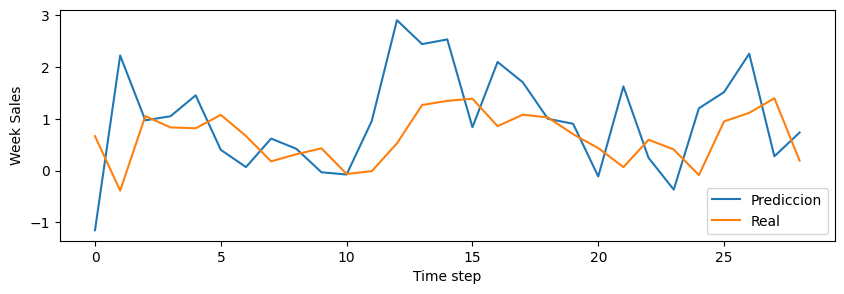

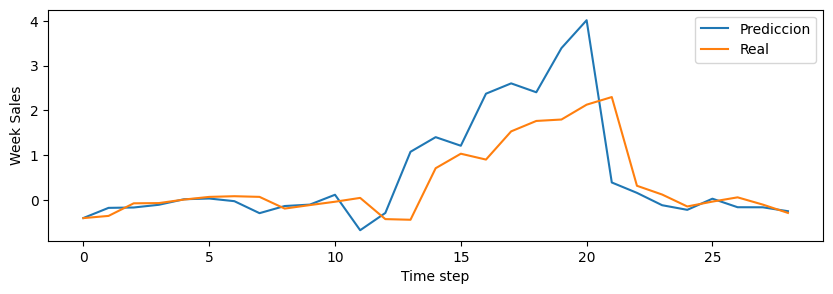

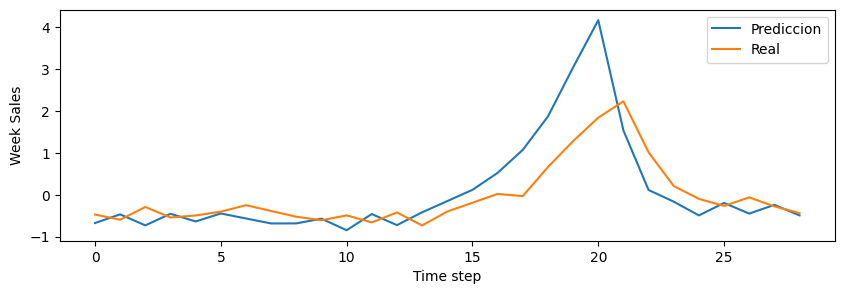

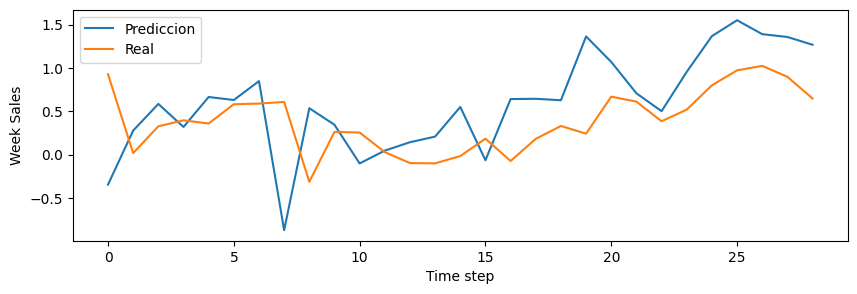

In [ ]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(10,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()

##CNN

Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [ ]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

###Cargar NARX

In [ ]:
result_gru=pd.read_csv('results_CNN_Wallmart.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
94,94,CNN_Wallmart_19_5_800_100.0_2.0_100.0_0.51_ada...,19,5,23.888380,0.412506,0.642267,0.460968,216.787018
213,213,CNN_Wallmart_43_4_800_10.0_2.0_200.0_0.46_adam...,43,4,108.787956,0.412562,0.642310,0.474048,237.853683
193,193,CNN_Wallmart_39_4_800_40.0_2.0_400.0_0.43_adam...,39,4,25.038480,0.425129,0.652019,0.475345,203.360809
68,68,CNN_Wallmart_14_4_800_70.0_2.0_700.0_0.66_adam...,14,4,27.102685,0.429269,0.655186,0.477540,241.695984
212,212,CNN_Wallmart_43_3_800_10.0_2.0_200.0_0.46_adam...,43,3,108.869204,0.429327,0.655230,0.470942,190.905502


In [ ]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo

'CNN_Wallmart_19_5_800_100.0_2.0_100.0_0.51_adam_4.926993343790581e-05_2_96.0'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_CNN'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.926993343790581e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Narmax

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], serie.shape[1],1))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [ ]:
target_shape

(142, 1)

In [ ]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [ ]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 3ms/step


###4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [ ]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.668983
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.309605
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.549603
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.643011


In [ ]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],Y_train_s.shape[1],1))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1],1))

###Exportar resultados Narmax


In [ ]:
result_mlp=pd.read_csv('Narmax_results_CNN_Wallmart.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
244,244,CNN_Wallmart_49_5_800_70.0_1.0_600.0_0.51_adam...,49,5,24.294567,0.505385,0.710904,0.540790,223.949005
89,89,CNN_Wallmart_18_5_800_50.0_1.0_200.0_0.55_adam...,18,5,22.325629,0.511323,0.715068,0.542675,221.989761
54,54,CNN_Wallmart_11_5_800_20.0_1.0_600.0_0.47_adam...,11,5,32.860205,0.512074,0.715594,0.545078,238.992401
218,218,CNN_Wallmart_44_4_800_100.0_2.0_800.0_0.48_ada...,44,4,27.067214,0.515072,0.717685,0.526251,198.767654
34,34,CNN_Wallmart_7_5_800_20.0_1.0_300.0_0.42_adam_...,7,5,46.262059,0.519170,0.720535,0.550608,241.812531


In [ ]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'CNN_Wallmart_49_5_800_70.0_1.0_600.0_0.51_adam_1.4292060726512047e-05_2_256.0'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_CNN'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1.4292060726512047e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [ ]:
Y_test.shape

(580, 1, 1)

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)
results = results.reshape(shape_y_test)
Y_test = Y_test.reshape(shape_y_test)


19/19 [==============================] - 0s 7ms/step


In [ ]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series_result_predict=divide_array(results,20)
series_result_real=divide_array(Y_test,20)

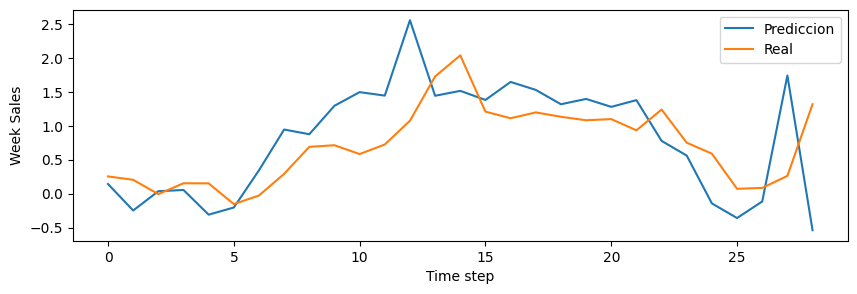

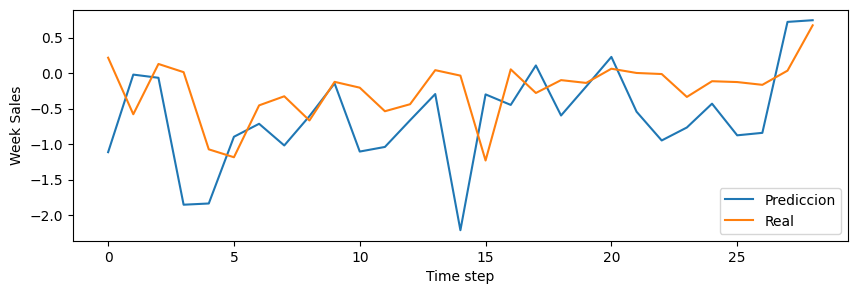

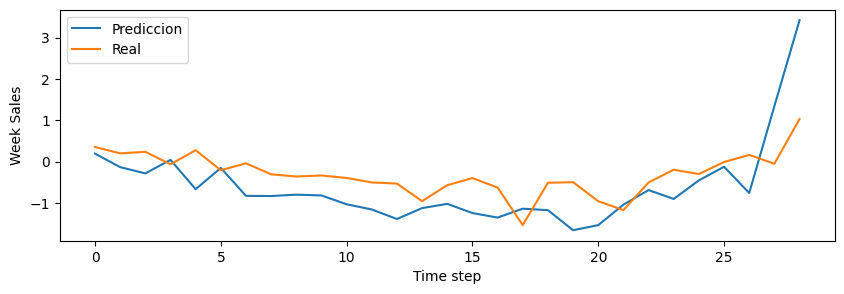

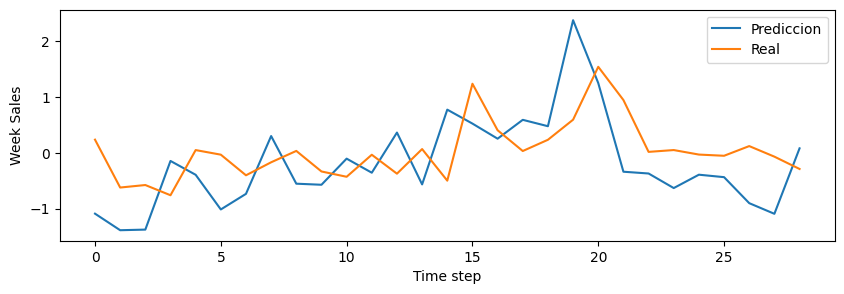

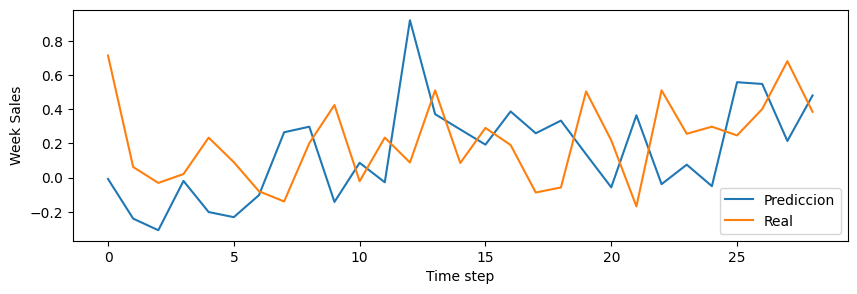

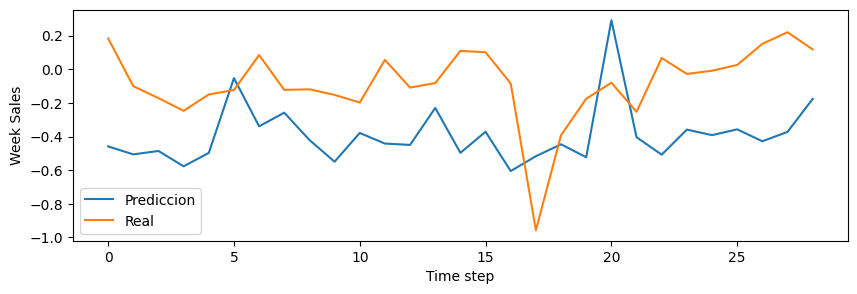

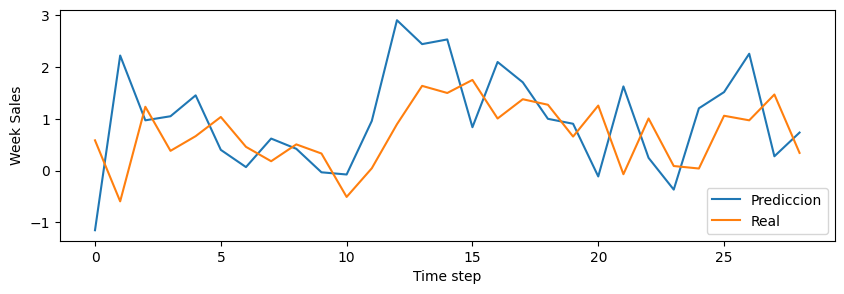

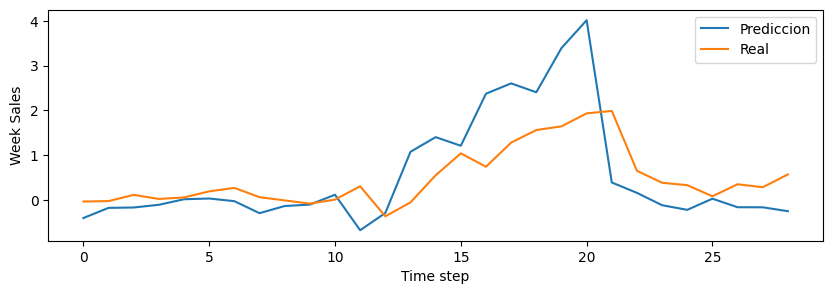

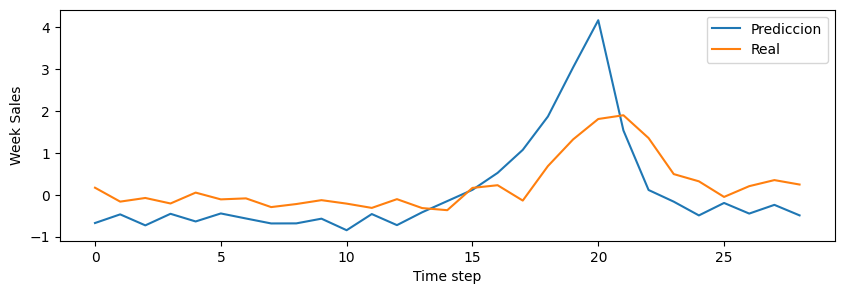

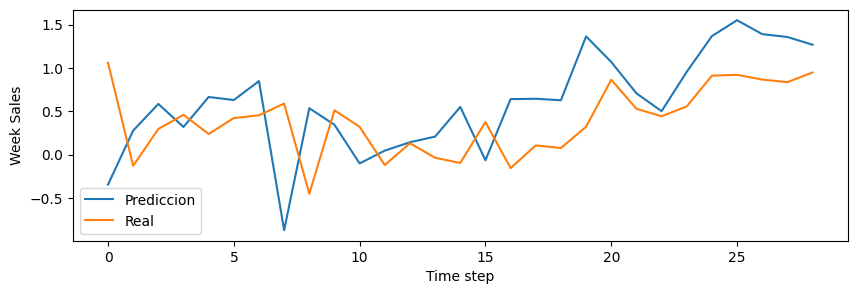

In [ ]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(10,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()

##MLP

Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [ ]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

###Cargar NARX

In [ ]:
result_gru=pd.read_csv('results_MLP_Wallmart.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
63,63,MLP_Wallmart_13_4_800_20.0_2.0_416.0_0.52_adam...,13,4,22.453038,0.452941,0.673009,0.497926,176.674988
23,23,MLP_Wallmart_5_4_800_70.0_1.0_224.0_0.49_adam_...,5,4,9.778895,0.454599,0.674240,0.500750,171.819305
24,24,MLP_Wallmart_5_5_800_70.0_1.0_224.0_0.49_adam_...,5,5,4.642483,0.460354,0.678494,0.505545,170.328751
248,248,MLP_Wallmart_50_4_800_20.0_1.0_224.0_0.46_adam...,50,4,13.896975,0.468057,0.684147,0.506974,168.532791
62,62,MLP_Wallmart_13_3_800_20.0_2.0_416.0_0.52_adam...,13,3,7.579901,0.468259,0.684294,0.510273,146.675659


In [ ]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo

'MLP_Wallmart_13_4_800_20.0_2.0_416.0_0.52_adam_4.88430493556068e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_MLP'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.926993343790581e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Narmax

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], serie.shape[1],1))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [ ]:
target_shape

(142, 1)

In [ ]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)

  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [ ]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 3ms/step


###4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [ ]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.549025
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.418742
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.527633
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.595844


In [ ]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


###Exportar resultados Narmax


In [ ]:
result_mlp=pd.read_csv('Narmax_results_MLP_Wallmart.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
234,234,MLP_Wallmart_47_5_800_50.0_1.0_192.0_0.45_adam...,47,5,35.658413,0.473573,0.688166,0.512811,173.433792
44,44,MLP_Wallmart_9_5_800_40.0_2.0_480.0_0.54_adam_...,9,5,47.038402,0.474728,0.689005,0.516164,176.453079
84,84,MLP_Wallmart_17_5_800_30.0_1.0_96.0_0.54_adam_...,17,5,119.476482,0.475598,0.689636,0.516714,180.814850
9,9,MLP_Wallmart_2_5_800_60.0_1.0_64.0_0.55_adam_3...,2,5,98.472659,0.477715,0.691169,0.519830,173.157806
49,49,MLP_Wallmart_10_5_800_60.0_1.0_448.0_0.46_adam...,10,5,28.136596,0.478909,0.692033,0.524919,187.875107


In [ ]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'MLP_Wallmart_47_5_800_50.0_1.0_192.0_0.45_adam_3.258898833057301e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_MLP'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1.4292060726512047e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [ ]:
Y_test.shape

(580, 1)

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)
results = results.reshape(shape_y_test)


19/19 [==============================] - 0s 2ms/step


In [ ]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series_result_predict=divide_array(results,20)
series_result_real=divide_array(Y_test,20)

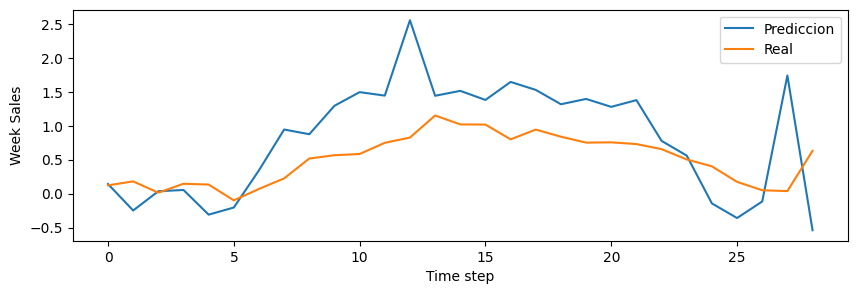

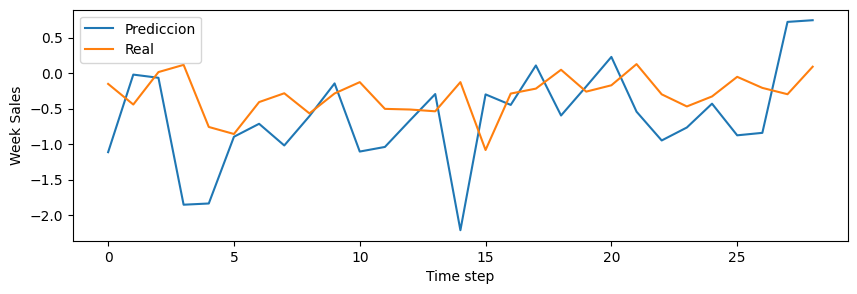

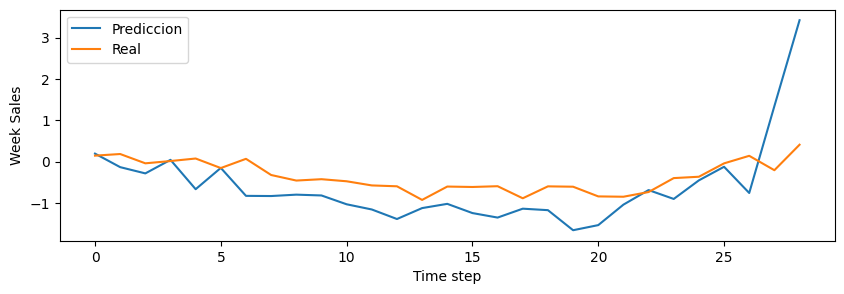

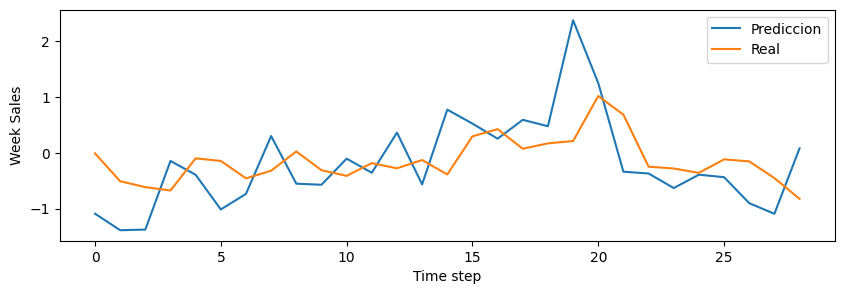

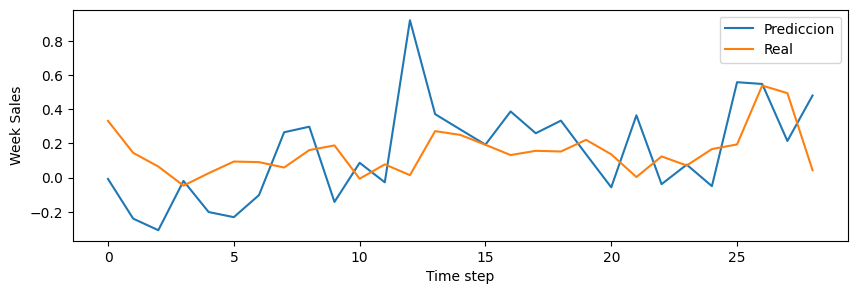

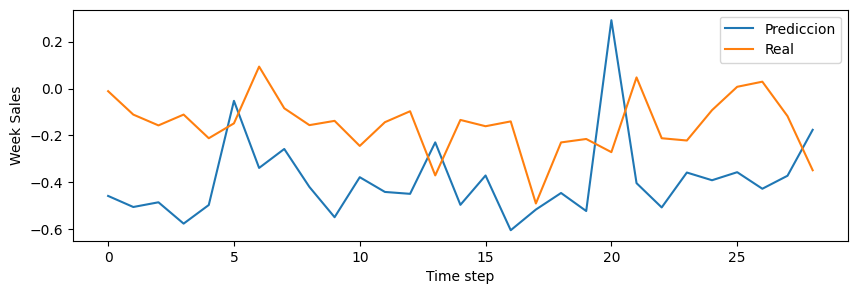

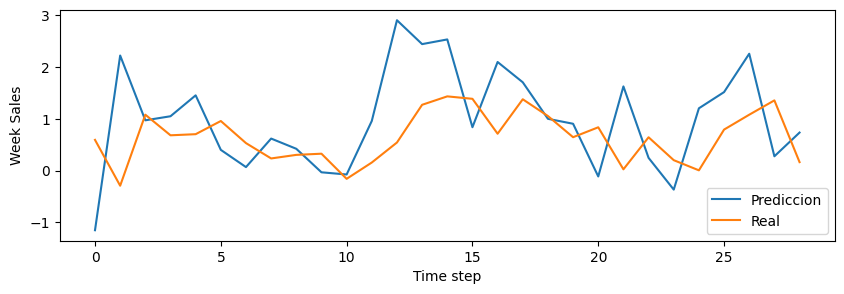

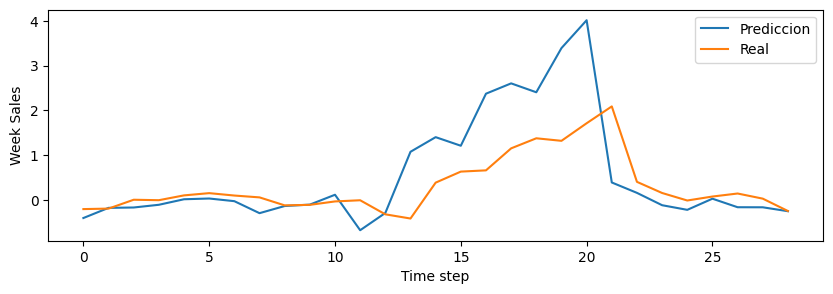

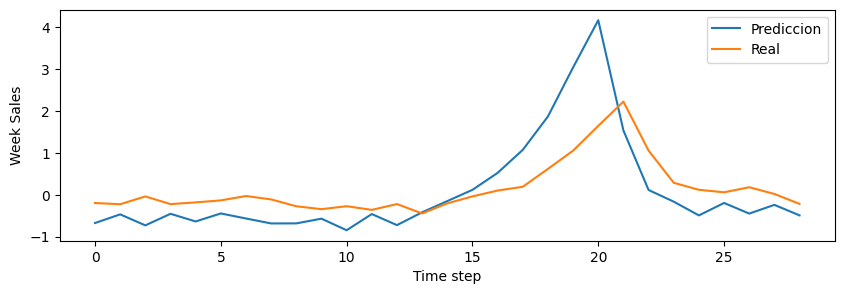

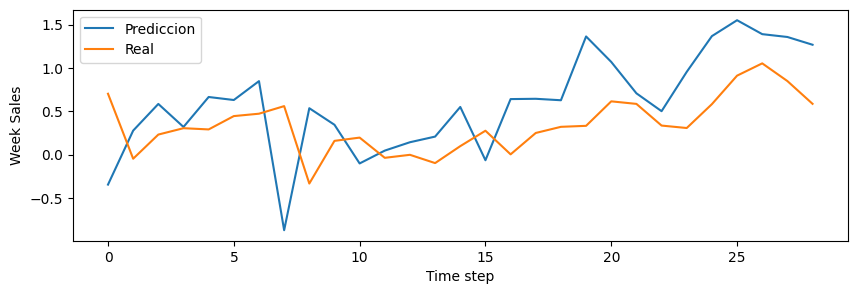

In [ ]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(10,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()

##LSTM

Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [ ]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

###Cargar NARX

In [ ]:
result_gru=pd.read_csv('results_LSTM_Wallmart.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
14,14,LSTM_Wallmart_3_5_800_30.0_2.0_352.0_0.43_adam...,3,5,138.101536,0.438978,0.662554,0.487419,228.010025
84,84,LSTM_Wallmart_17_5_800_30.0_3.0_448.0_0.42_ada...,17,5,233.119091,0.439021,0.662587,0.483972,232.810699
179,179,LSTM_Wallmart_36_5_800_20.0_2.0_288.0_0.6_adam...,36,5,307.499170,0.439200,0.662722,0.484254,218.693298
74,74,LSTM_Wallmart_15_5_800_70.0_3.0_512.0_0.5_adam...,15,5,182.062378,0.439808,0.663180,0.481646,211.900406
194,194,LSTM_Wallmart_39_5_800_40.0_2.0_288.0_0.59_ada...,39,5,228.578541,0.440231,0.663499,0.484051,209.963104


In [ ]:
nombre_archivo=result_gru['nameModel'].iloc[1]
nombre_archivo="LSTM_Wallmart_48_4_800_90.0_3.0_160.0_0.62_adam_1.2217000887388783e-05"

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_LSTM'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.563909354356966e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Narmax

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor= predictor.reshape((serie.shape[0], 1, serie.shape[1]))
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [ ]:
target_shape

(142, 1)

In [ ]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [ ]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,loaded_model,predictor,target_shape,1,target)
  series_time.append(aux)


5/5 [==============================] - 0s 3ms/step


###4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [ ]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-1.077063
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-1.045720
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-1.030508
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-1.083836


In [ ]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

###Exportar resultados Narmax


In [ ]:
result_mlp=pd.read_csv('Narmax_results_LSTM_Wallmart.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,index,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
224,224,LSTM_Wallmart_45_5_800_10.0_3.0_576.0_0.43_ada...,45,5,207.558187,0.028941,0.170121,0.130141,73.230339
239,239,LSTM_Wallmart_48_5_800_30.0_3.0_512.0_0.44_ada...,48,5,88.510653,0.033009,0.181683,0.137629,82.506393
219,219,LSTM_Wallmart_44_5_800_10.0_3.0_544.0_0.4_adam...,44,5,135.496402,0.033262,0.182379,0.136789,79.113075
214,214,LSTM_Wallmart_43_5_800_10.0_3.0_512.0_0.4_adam...,43,5,136.632851,0.035277,0.187820,0.137498,70.323288
199,199,LSTM_Wallmart_40_5_800_20.0_2.0_480.0_0.45_ada...,40,5,99.615921,0.037337,0.193229,0.137769,83.288086


In [ ]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo="Narmax_LSTM_Wallmart_50_1_800_10.0_3.0_352.0_0.48_adam_3.810577575275961e-05"

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_LSTM'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.705809759456389e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [ ]:
Y_test.shape

(580, 1)

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)
results = results.reshape(shape_y_test)
Y_test = Y_test.reshape(shape_y_test)


19/19 [==============================] - 1s 7ms/step


In [ ]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [ ]:
series_result_predict=divide_array(results,20)
series_result_real=divide_array(Y_test,20)

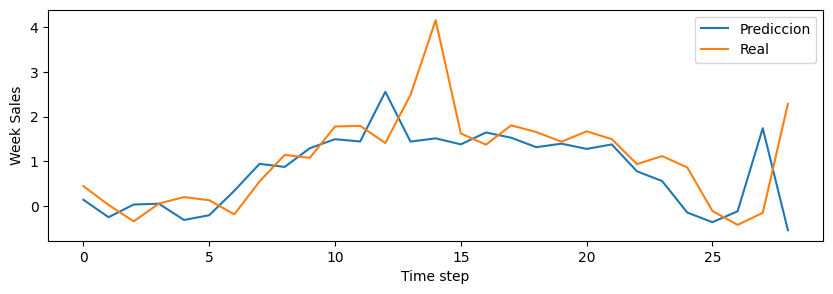

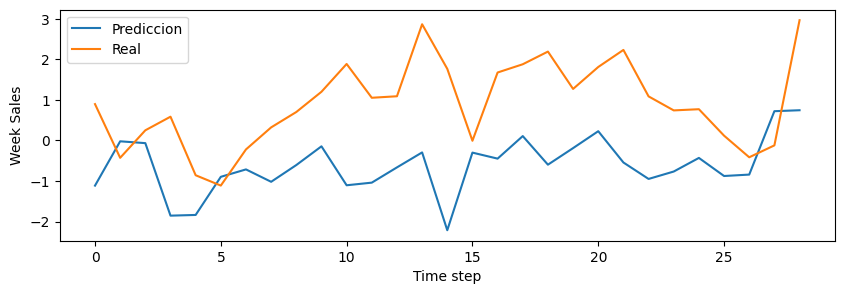

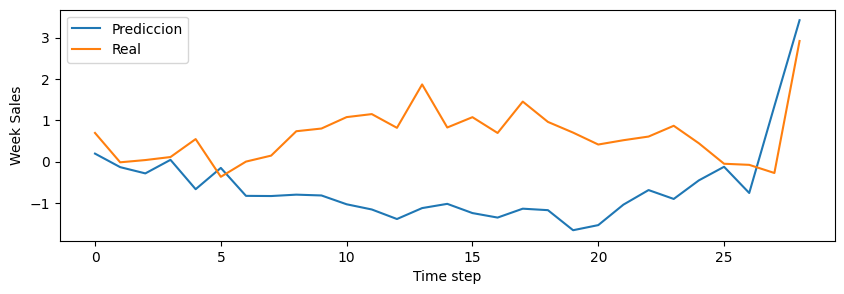

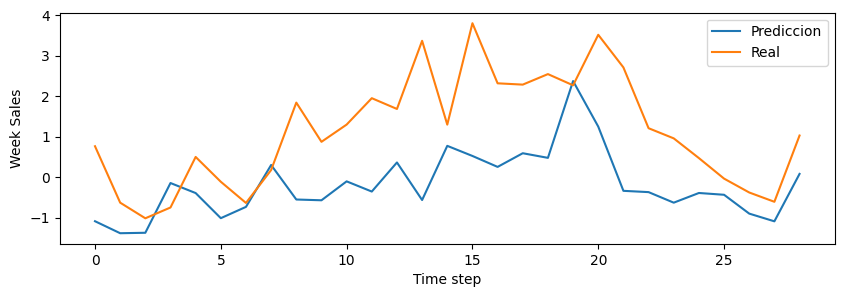

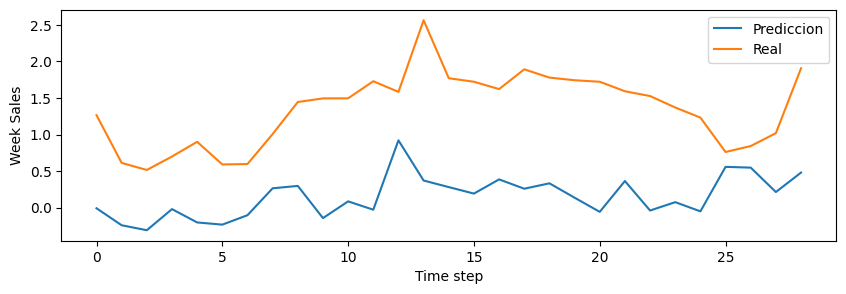

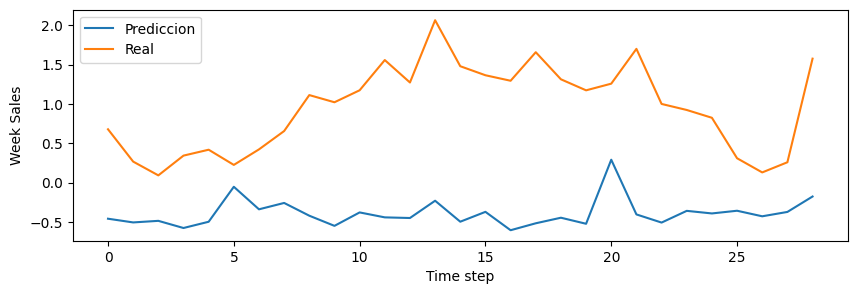

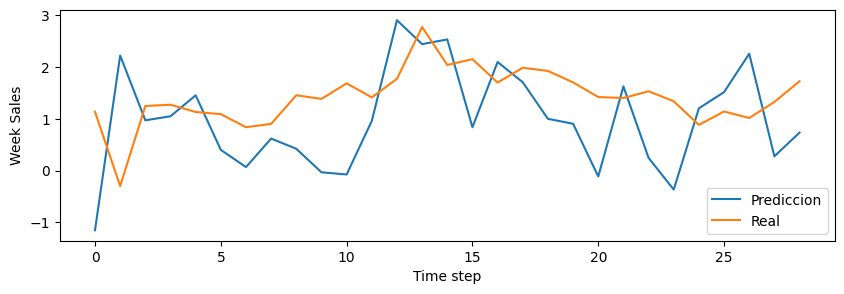

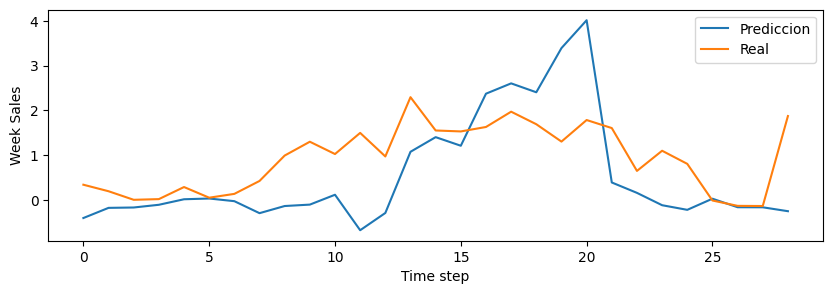

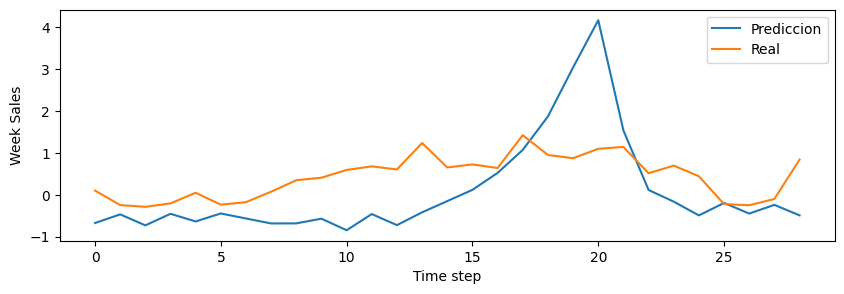

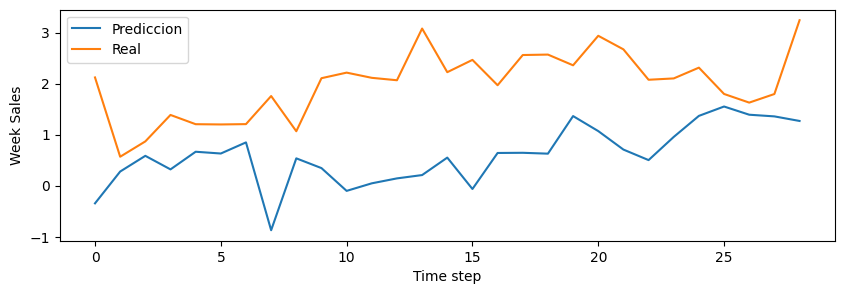

In [ ]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(10,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()

##SVR

In [59]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [60]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [61]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

In [62]:
import joblib

In [63]:
result_svr=pd.read_csv('results_SVR_Wallmart.csv')
result_svr = result_svr.sort_values(by='MSE', ascending=True)
result_svr.head(5)

,index,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
101,101,SVR_Wallmart_21_2_linear_0.1_0.2_scale,21,2,0.089041,0.411165,8.750326,0.641222,0.477221
196,196,SVR_Wallmart_40_2_linear_0.1_0.2_scale,40,2,0.090399,0.411165,8.750326,0.641222,0.477221
156,156,SVR_Wallmart_32_2_linear_0.1_0.2_scale,32,2,0.096840,0.411165,8.750326,0.641222,0.477221
139,139,SVR_Wallmart_28_5_linear_0.1_0.1_scale,28,5,0.549153,0.412342,9.551642,0.642138,0.478596
109,109,SVR_Wallmart_22_5_linear_0.1_0.1_scale,22,5,0.543340,0.412342,9.551642,0.642138,0.478596


In [64]:
nombre_archivo=result_svr['nameModel'].iloc[0]
nombre_archivo="SVR_linear_0.1_0.2_scale"

In [65]:
nombre_json=nombre_archivo+"."+"pkl"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_SVR'
ruta = os.path.join(carpeta_destino, nombre_json)

In [66]:
load_model = joblib.load(ruta) # Carga del modelo.


###Narmax

In [67]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor_variable.append(predictor)

  target=np.array(target)
  target_variable.append(target)
  target_shape=target.shape

In [70]:
predictor_variable[0].shape

(142, 13)

In [71]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)

  target=np.array(target_variables)

  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [72]:
series_time=[]
for serie,predictor,target in zip(series,predictor_variable,target_variable):
  aux=narmax_data(serie,load_model,predictor,target_shape,1,target)
  series_time.append(aux)


###4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [73]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [74]:
series_predic=[]
series_target=[]
for serie in series_time:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [75]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head(4)

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0),error(t-0)
Date,,,,,,,,,,,,,,
2010-02-19,7.0,9.0,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,-0.329480
2010-02-26,7.0,9.0,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.343897
2010-03-05,7.0,9.0,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.310874
2010-03-12,7.0,9.0,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.382358


In [76]:
#Ejemplo de variables objetivo de una serie
series_target[0].head(4)

,Weekly_Sales(t+1)
Date,
2010-02-19,-1.055308
2010-02-26,-1.026079
2010-03-05,-1.077562
2010-03-12,-1.053027


In [77]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


###Exportar resultados Narmax


In [82]:
result_mlp=pd.read_csv('Narmax_results_SVR_Wallmart.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
144,144,SVR_Wallmart_29_5_linear_1_0.2_auto,29,5,2.730910,0.445496,2.054747,0.667455,0.481996
149,149,SVR_Wallmart_30_5_linear_1_0.2_auto,30,5,2.757076,0.445496,2.054747,0.667455,0.481996
164,164,SVR_Wallmart_33_5_linear_1_0.2_auto,33,5,2.732210,0.445496,2.054747,0.667455,0.481996
174,174,SVR_Wallmart_35_5_linear_1_0.2_auto,35,5,2.730505,0.445496,2.054747,0.667455,0.481996
199,199,SVR_Wallmart_40_5_linear_1_0.2_auto,40,5,2.733136,0.445496,2.054747,0.667455,0.481996


In [83]:
nombre_archivo=result_svr['nameModel'].iloc[0]
nombre_archivo="SVR_linear_0.1_0.2_scale"

In [84]:
nombre_json=nombre_archivo+"."+"pkl"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/Narmax_result_SVR'
ruta = os.path.join(carpeta_destino, nombre_json)

In [85]:
load_model = joblib.load(ruta) # Carga del modelo.


In [86]:
Y_test.shape

(580, 1)

In [88]:
#Se realiza prediccion
results = load_model.predict(X_test)


In [89]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [90]:
series_result_predict=divide_array(results,20)
series_result_real=divide_array(Y_test,20)

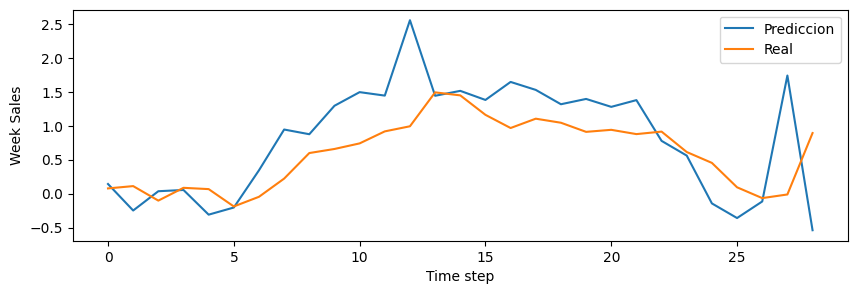

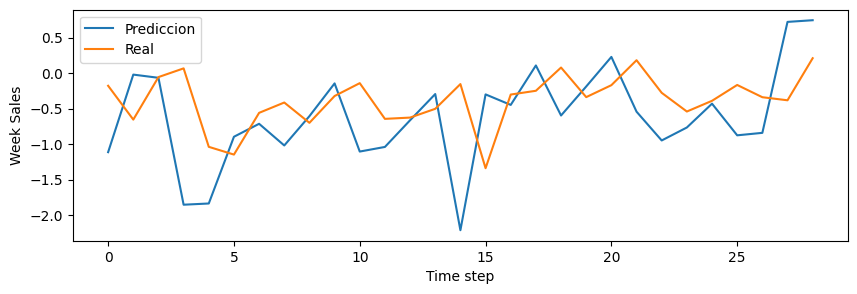

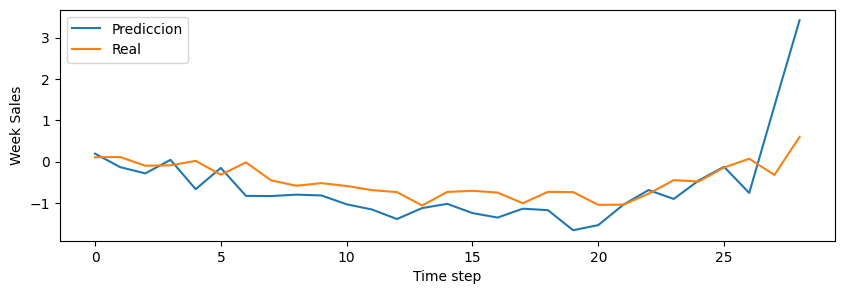

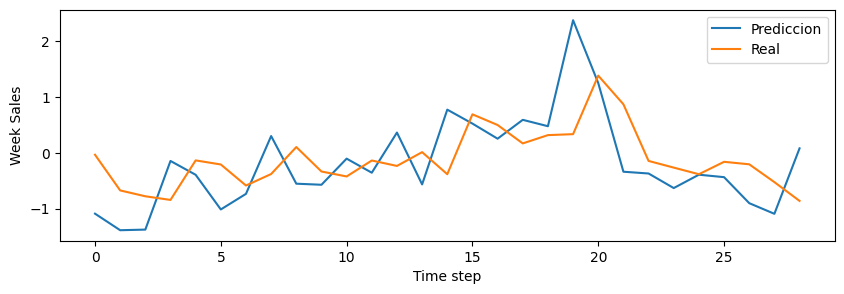

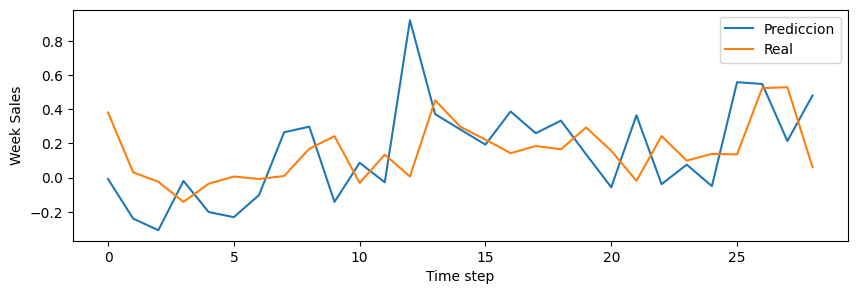

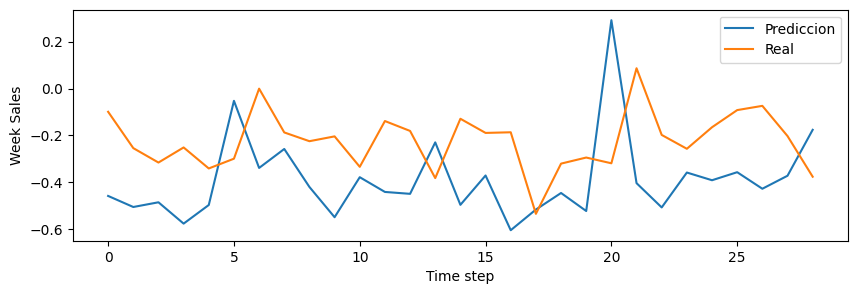

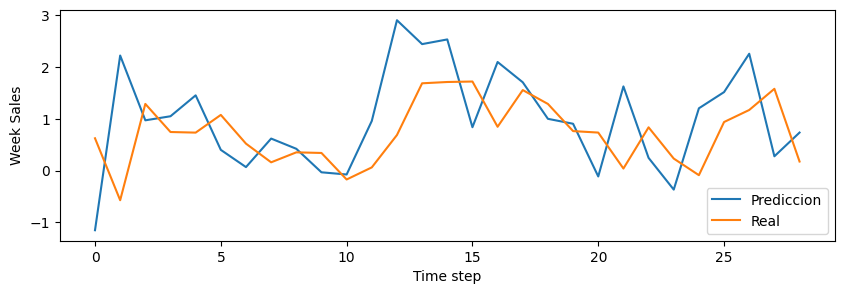

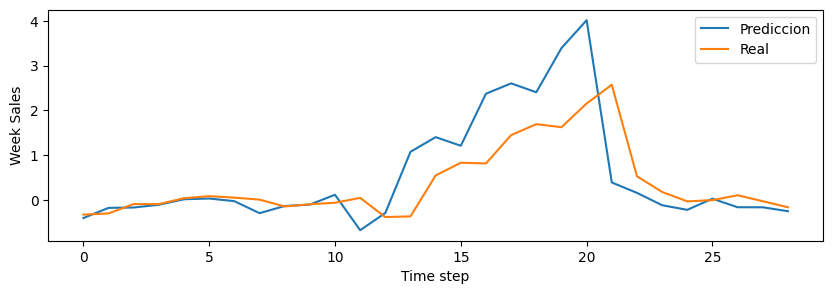

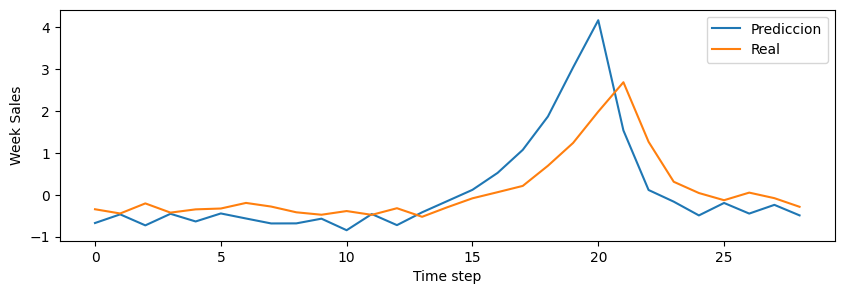

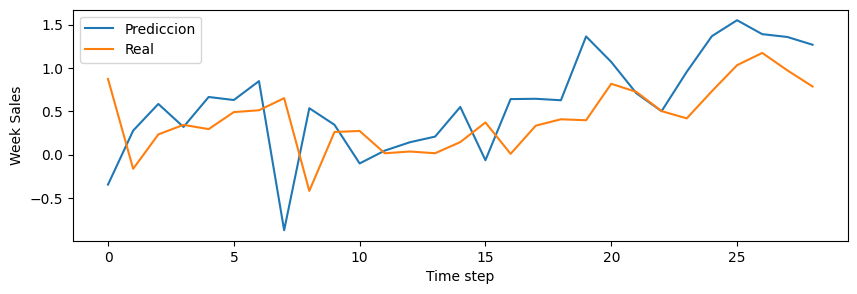

In [91]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(10,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()